In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import scipy
import math
from math import inf, log
import queue as Q
np.random.seed = 0

In [2]:
def exponential(lamda, k):
    return np.random.exponential(scale=1/lamda, size=k)

def gaussian(mean, sigma, k):
    return np.random.normal(loc=mean, scale=sigma, size=k)


In [4]:
def generate_column_stochastic_matrix(n):
    # Doesn't generate a sparse matrix. The degree of each link can be as high as n-1. 
    # Todo: Think of how to make a sparse matrix (to mimic road network geometry)
    A = np.random.rand(n,n)
    temp = np.random.choice([0,1], (n,n), p=[0.8,0.2])
    A = np.multiply(A, temp)
    A = A/A.sum(axis=0)
    return A

def generate_signal(st):
    # deterministically right shifts each signal in the signal vector
    s = []
    s.append(st[-1])
    s.extend(st[:-1])
    return s



In [5]:
def signalized(A, signal):
    # signal is a n length vector, which determines the signal on that specific link. Takes values 0 or 1
    # convention: 1 for red, 0 for green
    for i in range(len(signal)):
        if signal[i]==1:
            A[:,i] = [1 if j==i else 0 for j in range(len(signal))]
    
    return A

In [6]:
def state_transition(A, xt, st, mean=0, sigma=0.1, signal_flag=0):
    c = 1
    wt = 1*gaussian(mean, sigma, len(xt))
    # if signalized intersections are used
    if signal_flag==1:

        st = generate_signal(st)
        x_t1 = np.matmul(signalized(A, st), xt) + wt
    else:
        x_t1 = np.matmul(A, xt) + wt

    x_t1 = np.minimum(np.maximum(x_t1, np.zeros(len(xt))), c* np.ones(len(xt)))
    
    return x_t1, st

In [38]:
time_steps = 100
size= 10
A = generate_column_stochastic_matrix(size)
# st = np.random.choice([0,1], size=size, p=[1./3, 2./3])

W = []
for i in range(time_steps):
    W.append( gaussian(0,0.1, size))
    



In [45]:
xt = x_init = np.ones(size)/size
mean = 0
X = []
S = []
X.append(x_init)
S.append(st)
# print(A, A.sum(axis=0))

for i in range(time_steps):
    
    xt, st = state_transition(A, xt, st, mean=mean, signal_flag=0)

    X.append(xt)
    S.append(st)

    #     print(mean)

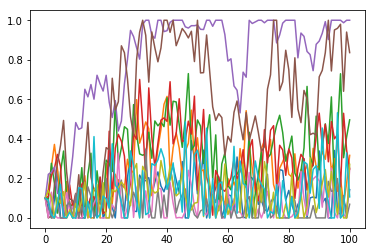

In [46]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()
X = np.array(X)
S = np.array(S)
for i in range(size):
    plt.plot(X[:,i])

# for j in range(size):
#     plt.plot(S[:,i])

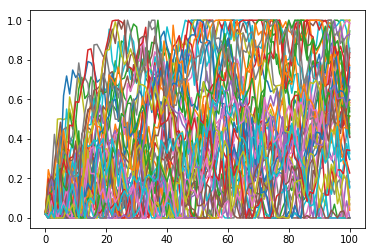

In [26]:
%matplotlib inline
X = np.array(X)
S = np.array(S)
for i in range(size):
    plt.plot(X[:,i])

# for j in range(size):
#     plt.plot(S[:,i])

In [ ]:
def greedy(A, xt, source, destination):
    # source is the current link and the destination is the destination link
    print(xt)
    next_node = None
    min_cost = inf
    for j in get_adjacent_edges(A, source):
        if (j != source) and (A[j,source]>0):
            if min_cost > xt[j]:
                next_node = j
                min_cost = xt[j]
            if j == destination:
                next_node = j
                min_cost = xt[j]
                break
    # this part deals with when there is no way out from the current link. (Have to deal with this separately
    # in the signalized case.)
#     if next_node==None:
#         next_node = source
#         min_cost = xt[source]
    
    return next_node, min_cost

In [ ]:
"""Variant of dijkstra implementation. Here A is not adjacency matrix wrt nodes, but wrt edges. so A(i,j) doesn't
add any significance apart from determining the adjacent edges. The cost computation is performed using xt. 
"""

def get_adjacent_edges(A, current_edge):
    adj = []
    for i in range(A.shape[0]):
        if A[current_edge, i] >0:
            adj.append(i)
    return adj

class Edge:
    def __init__(self):
        self.distance = math.inf
        self.parent = None

        
    
def dijkstra(A, xt, source, destination):

    edges = [Edge() for j in range(len(xt))]
    edges[source].distance = 0

    colored_edges = []

    q = Q.PriorityQueue()
    for j in range(len(xt)):
        q.put((edges[j].distance, j))

    while not q.empty():
        _, current_edge = q.get()
        if current_edge not in colored_edges: 
            colored_edges.append(current_edge)
        adj = get_adjacent_edges(A, current_edge)
        for j in adj:
            if edges[j].distance > edges[current_edge].distance + xt[j]:
                edges[j].distance = edges[current_edge].distance + xt[j]
                edges[j].parent = current_edge
                
    if destination not in colored_edges:
        print("no route found")
                
    return edges, colored_edges
                

def dijkstra_policy(A, xt, source, destination):
    # chooses just the next edge to traverse
    path = []
    edges, colored_edges = dijkstra(A, xt, source, destination)
#     print(colored_edges)
#     for e in edges:
#         print(e.parent, e.distance)
    if (edges[destination].distance is not inf):
        # path is found
        prev = destination #edges[destination].parent
#         path.append(prev)
        while prev is not None:
            temp = edges[prev].parent
            path.append(temp)
            if temp==source:
                decision = prev
                break
            prev = temp

        return decision, edges[destination].distance
    else:
        print("taking greedy")
        return greedy(A, xt, source, destination)

In [ ]:
size=5
xt = np.random.rand(size)
xt = xt/xt.sum()
st = np.random.choice([0,1], size=size, p=[2./3, 1./3])
A=generate_column_stochastic_matrix(size)
A

In [ ]:
ed = dijkstra(A, xt, source=0, destination=size-1)
print(xt)
for e in ed:
    print(e.distance, e.parent)

In [ ]:

v : US
lang : EN
Watch Long Flash Porn Videos for FREE
def follow_model(A, x_init, s_init, source, destination, policy, signal_flag=0):

    xt = x_init
    st = s_init
    X = []
    S = []
    X.append(xt)
    S.append(st)

    current_link = source
    cost_incurred = 0

#     print(current_link, cost_incurred, xt, destination)
    
    while current_link is not destination:
        decision,_ = policy(A, xt,current_link, destination)
        if decision is None:
            print("no connection")
            break
            
        xt, st = state_transition(A, xt, st, signal_flag=signal_flag)
        X.append(xt)
        S.append(st)
#         if decision is not None:
        cost_incurred += compute_cost(xt, decision)
#         print(decision, cost_incurred)
        current_link = decision
        print(current_link, cost_incurred, destination)
#         print(current_link, cost_incurred, st, destination)
        if len(X) == 10 * len(x_init)**2:
            break
#         else:
#             print("no path found")
#             break
        
    return cost_incurred

def cost_function(x):
    # think of a better cost function that is smooth and monotone increasing
#     return log(1+x)
    return math.exp(x)

def compute_cost(xt, current_link):
#     return xt[current_link]
    return cost_function(xt[current_link])


In [ ]:
size=100
xt = np.random.rand(size)
xt = xt/xt.sum()
st = np.random.choice([0,1], size=size, p=[2./3, 1./3])
A=generate_column_stochastic_matrix(size)


In [ ]:
for j in range(len(xt)):
    print("j=",j)
    follow_model(A, xt,st, source=6, destination=j, policy=dijkstra_policy, signal_flag=0)
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")